# estimate numba over heads on differnt argument types

In [1]:
from numba import njit ,types as nbt, typeof, from_dtype
from numba.experimental import jitclass
import numpy as np
from timeit import timeit
from time import perf_counter
from typing import NamedTuple

S  = np.dtype([('f0', '<i4'), ('f1', '<f8', (2, 3))])

@njit()
def K(a):
    s= 0.
    for n in range(a.size):
        s +=  np.sin(a[n])*n +2.*a[n]
    return s

@njit()
def K2(a1,a2):
    s= 0.
    for n in range(a1.size):
        s += np.sin(a1[n])*n + 2.*a2[n]
    return s

@njit()
def F1(a):   
    return  K(a)

@njit()
def F12(a1,a2):   
    return  K2(a1,a2)   
       

@njit
def FS(S): 
    return  K(S['val'])


@njit
def FS2(s1,s2): 
    return  K2(s1['val'],s2['val'])

@njit
def FC(a):      
    return K(a.val)
@njit
def FC2(a1, a2):      
    return K2(a1.val, a2.val)
@njit    
def FNT(a):      
    return K(a.val)

@njit    
def FNT2(a1,a2):      
    return K2(a1.val,a2.val)

repeats = 100
#work = np.asarray([2,5,10,20, 50,75, 10**2,500, 10**3,10**4,10**5],dtype=np.int32)
work = np.asarray([1,10,100],dtype=np.int32)

M = 2
N = work.size
t1= np.zeros((N,M),dtype=np.float64)
tnt= np.zeros((N,M),dtype=np.float64)

nfields=np.asarray([1,2,10,20])
ts= np.zeros((N,M),dtype=np.float64)
tc= np.zeros((N,M),dtype=np.float64)

val = 10.6

for n ,w in enumerate(work):    
    #  base case
    a1 = np.random.rand(w)
    a2 = a1.copy()
    F1(a1)  # compile
    t1[n,0]=  timeit(lambda  : F1(a1),  number =repeats) 
    F12(a1,a1)  # compile
    t1[n,1]=  timeit(lambda  : F12(a1,a2),  number =repeats)
    
    # base numpy record
    s = np.zeros((1,),dtype=[('val', 'f8', a1.size)])[0]

    FS(s) # compile
    ts[n,0]=  timeit(lambda  : FS(s),  number =repeats)
    FS2(s,s) # compile
    ts[n,1]=  timeit(lambda  : FS2(s,s),  number =repeats)

    # base class
    @jitclass([('val', nbt.float64[:])])
    class ContainerHolder(object):
        def __init__(self,val) -> None:            
            self.val = val  
    c= ContainerHolder(a1)     
    
    FC(c) # compile
    tc[n,0]=  timeit(lambda  : FC(c),  number =repeats)
    FC2(c ,c ) # compile
    tc[n,1]=  timeit(lambda  : FC2(c ,c),  number =repeats)
            
    # named tuple approach
    class NT(NamedTuple):  
        N : int  = N                
        val  : np.ndarray = a1 
    nt = NT()
    FNT(nt) # compile     
    tnt[n,0]=  timeit(lambda  : FNT(nt),  number =repeats) 
    FNT2(nt,nt) # compile     
    tnt[n,1]=  timeit(lambda  : FNT2(nt,nt),  number =repeats) 
       
        
# convert msec    
t1 = 1000*t1
ts = 1000*ts 
tc= 1000*tc  
tnt= 1000*tnt  

from matplotlib import pyplot as plt
fig,ax = plt.subplots()

ax.plot(work,t1[:,0],label =f'explict 1 args.')
ax.plot(work,t1[:,1],label =f'explict 2 args.')
ax.plot(work,ts[:,0],label = f'dtype struct 1 args')
ax.plot(work,ts[:,1],label = f'dtype struct 2 args')
ax.plot(work,tc[:,0],label = f'jit class 1 arg')
ax.plot(work,tc[:,1],label = f'jit class 2 arg')
ax.plot(work,tnt[:,0],label =f'named tuple 1 arg')
ax.plot(work,tnt[:,1],label =f'named tuple 2 args')


plt.xscale('log')
plt.yscale('log')
#ax.plot(ax.get_xlim(),ax.get_xlim(),c=[.8,.8,.8])
ax.legend(prop={'size': 8})
ax.set_ylabel('time per call, mSec')
ax.set_xlabel('loop count')

C:\Users\rossv\AppData\Local\Temp\ipykernel_472\790168857.py:82: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  s = np.zeros((1,),dtype=[('val', 'f8', a1.size)])[0]


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'size' of type float64
[1m
File "C:\Users\rossv\AppData\Local\Temp\ipykernel_472\790168857.py", line 13:[0m
[1mdef K(a):
    <source elided>
    s= 0.
[1m    for n in range(a.size):
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at C:\Users\rossv\AppData\Local\Temp\ipykernel_472\790168857.py (13)[0m
[1m
File "C:\Users\rossv\AppData\Local\Temp\ipykernel_472\790168857.py", line 13:[0m
[1mdef K(a):
    <source elided>
    s= 0.
[1m    for n in range(a.size):
[0m    [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function K at 0x00000183AFB491B0>))[0m
[0m[1mDuring: typing of call at C:\Users\rossv\AppData\Local\Temp\ipykernel_472\790168857.py (35)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function K at 0x00000183AFB491B0>))[0m
[0m[1mDuring: typing of call at C:\Users\rossv\AppData\Local\Temp\ipykernel_472\790168857.py (35)
[0m
[1m
File "C:\Users\rossv\AppData\Local\Temp\ipykernel_472\790168857.py", line 35:[0m
[1mdef FS(S): 
[1m    return  K(S['val'])
[0m    [1m^[0m[0m


In [3]:
a



NameError: name 'a' is not defined

Text(0.5, 0, 'loop count')

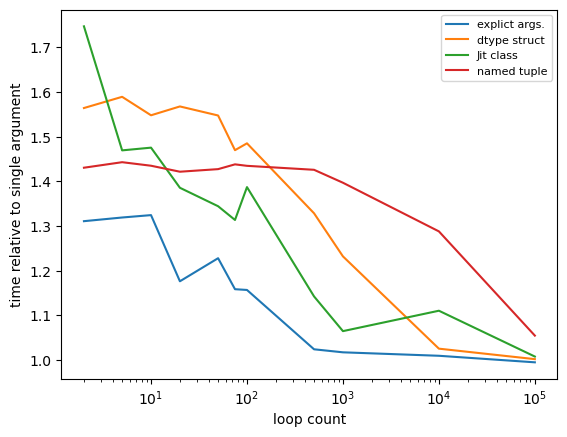

In [ ]:
# plot relative time 1 to two args
fig,ax = plt.subplots()
ax.plot(work,t1[:,1]/t1[:,0], label =f'explict args.')
ax.plot(work,ts[:,1]/ts[:,0], label =f'dtype struct')
ax.plot(work,tc[:,1]/tc[:,0], label =f'Jit class')
ax.plot(work,tnt[:,1]/tnt[:,0], label =f'named tuple')
if False:
    ax.plot(work,t1/work,label =f'explict args.')
    ax.plot(work,ts/work,label = f'dtype struct')
    ax.plot(work,tc/work,label = f'jit class')
    #ax.plot(work,tnt/work,label =f'named tuple')
ax.set_xscale('log')

#ax.plot(ax.get_xlim(),ax.get_xlim(),c=[.8,.8,.8])
ax.legend(prop={'size': 8})
ax.set_ylabel('time relative to single argument')
ax.set_xlabel('loop count')